<a href="https://colab.research.google.com/github/sys-unknwn7645/Classification-of-Lung-and-Colon-Cancer-Tissues-from-Histopathological-Image/blob/main/IE7860_Semester_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Importing and Pre-Processing

Importing necessary packages and prepping to import from google drive

Dataset downloaded from: https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images

In [ ]:
!pip install keras_tuner

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import keras
import cv2
import keras
import keras_tuner as kt
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing data

In [ ]:
import zipfile
import os

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/lung_colon_image_set.zip', 'r') #Opens the zip file in read mode
#zip_ref = zipfile.ZipFile('/content/lung_colon_image_set.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

In [ ]:
data = pathlib.Path('/tmp/lung_colon_image_set')

# Setting Data

Setting batch size and image height

In [ ]:
batch_size = 16
img_height = 128
img_width = 128


Importing data into tensorflow datasets and setting up train/validation/test split

In [ ]:
seed_train_validation = 123 # Must be same for train_ds and val_ds
shuffle_value = True
validation_split = 0.3

train_ds = tf.keras.utils.image_dataset_from_directory(
data,
image_size = (img_height, img_width),
validation_split = validation_split,
subset = "training",
seed = seed_train_validation,
shuffle = shuffle_value)

val_ds = tf.keras.utils.image_dataset_from_directory(
data,
image_size = (img_height, img_width),
validation_split = validation_split,
subset = "validation",
seed = seed_train_validation,
shuffle = shuffle_value)

val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take((2*val_batches) // 3)
val_ds = val_ds.skip((2*val_batches) // 3)

Found 25000 files belonging to 5 classes.
Using 17500 files for training.
Found 25000 files belonging to 5 classes.
Using 7500 files for validation.


Checking the classes

In [ ]:
class_names = train_ds.class_names
print(class_names)

['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Creating Base CNN

Setting the number of classes and defining a base sequential CNN model

In [ ]:
num_classes = 5

basemodel = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(96, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])


Compiling our model with the adam optimizer, Sparse Categorical Crossentropy loss, and using accuracy as our performance metric

In [ ]:
basemodel.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])


Setting epochs to 50, and fitting the model on our training and validation datasets

In [ ]:
num_epochs = 50
history = basemodel.fit(
  train_ds,
  validation_data=val_ds,
  epochs=num_epochs
)

In [ ]:
eval = basemodel.evaluate(test_ds)

Plotting the accuracy and loss curves

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


# Creating Custom CNN

Checking to see images look correct

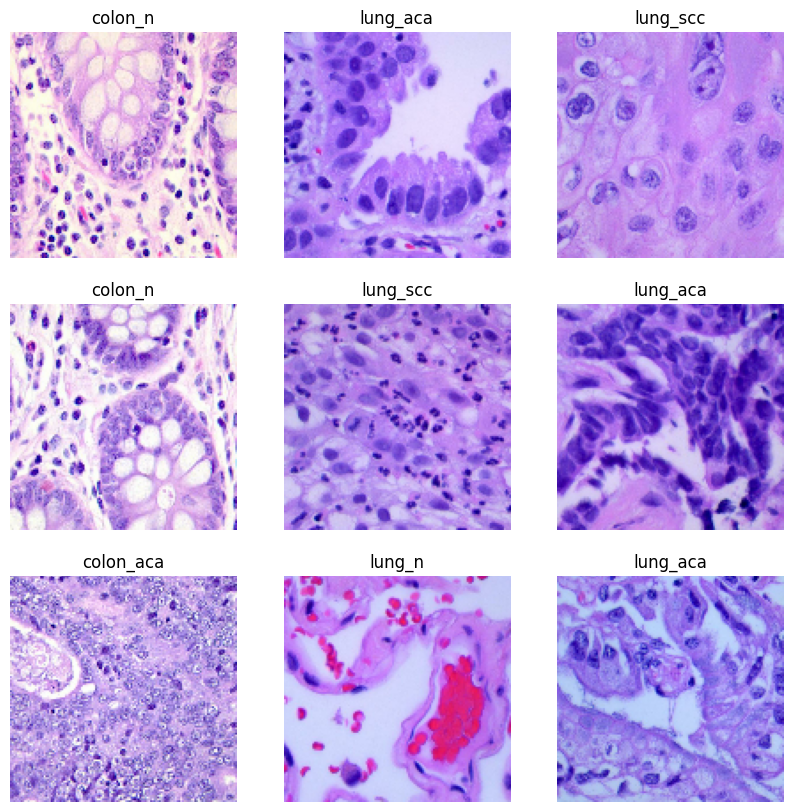

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


Setting our number of classes and defining our sequential CNN model.

In [ ]:
num_classes = 5

cmodel = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])


Same as base CNN

In [ ]:
cmodel.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])


Same as base CNN

In [ ]:
num_epochs = 50
history = cmodel.fit(
  train_ds,
  validation_data=val_ds,
  epochs=num_epochs
)

Epoch 1/5
547/547 [==============================] - 79s 140ms/step - loss: 0.7255 - accuracy: 0.6521 - val_loss: 0.4587 - val_accuracy: 0.8054
Epoch 2/5
547/547 [==============================] - 10s 18ms/step - loss: 0.4785 - accuracy: 0.7900 - val_loss: 0.3357 - val_accuracy: 0.8692
Epoch 3/5
547/547 [==============================] - 10s 18ms/step - loss: 0.3624 - accuracy: 0.8539 - val_loss: 0.3137 - val_accuracy: 0.8788
Epoch 4/5
547/547 [==============================] - 9s 17ms/step - loss: 0.2698 - accuracy: 0.8978 - val_loss: 0.2122 - val_accuracy: 0.9211
Epoch 5/5
547/547 [==============================] - 10s 18ms/step - loss: 0.2200 - accuracy: 0.9161 - val_loss: 0.1828 - val_accuracy: 0.9318


In [ ]:
eval = cmodel.evaluate(test_ds)

156/156 [==============================] - 14s 78ms/step - loss: 0.1651 - accuracy: 0.9385


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
cmodel.summary()


ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

# Creating Hypertuning Model

Let's define our model once again, adding in the necessary functions for hyperparameter tuning with keras tuner

In [ ]:
def model_build(hp):
    num_classes = 5

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Rescaling(1./255),)
    model.add(tf.keras.layers.Conv2D(32, 3, activation='relu'),)
    model.add(tf.keras.layers.MaxPooling2D(),)
    model.add(tf.keras.layers.Conv2D(64, 3, activation='relu'),)
    model.add(tf.keras.layers.MaxPooling2D(),)
    model.add(tf.keras.layers.Conv2D(128, 3, activation='relu'),)
    model.add(tf.keras.layers.MaxPooling2D(),)
    model.add(tf.keras.layers.Flatten(),)
    if hp.Boolean("dropout"):
        model.add(tf.keras.layers.Dropout(rate=0.3))
    model.add(tf.keras.layers.Dense(64, activation='relu'),)
    if hp.Boolean("dropout"):
        model.add(tf.keras.layers.Dropout(rate=0.3))
    model.add(tf.keras.layers.Dense(32, activation='relu'),)
    model.add(tf.keras.layers.Dense(num_classes))
    #model end

    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    return model
model_build(kt.HyperParameters())

Setting up our tuner to go for 6 trials, 2 executions per trial, and trying to maximize the validation accuracy

In [ ]:
tuner = kt.RandomSearch(
    hypermodel=model_build,
    objective="val_accuracy",
    max_trials=6,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir",
    project_name="helloworld",
)

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 2
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [ ]:
tensorboard_callback = keras.callbacks.TensorBoard("./content/tb_logs") # The logs will be written to "/content/tb_logs".

Initiating the search. This will take a while

In [ ]:
tuner.search(train_ds, epochs=5, validation_data=(val_ds),callbacks = [ tensorboard_callback])

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/tb_logs

# Setting up Transfer Learning with ResNet50

ResNet50 requires an image size of 224x224

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 16

In [ ]:
res_train_ds = tf.keras.utils.image_dataset_from_directory(data,validation_split=0.3,subset="training",seed=123,image_size=IMG_SIZE,batch_size=BATCH_SIZE)
res_val_ds = tf.keras.utils.image_dataset_from_directory(data,validation_split=0.3,subset="validation",seed=123,image_size=IMG_SIZE,batch_size=BATCH_SIZE)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

res_train_ds = res_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
res_val_ds = res_val_ds.cache().prefetch(buffer_size=AUTOTUNE)


Preprocessing our input images using resnet50's built in preprocessor, rescaling our images, and defining a prediction layer

In [ ]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input
rescale = tf.keras.layers.Rescaling(1./255)
prediction_layer = tf.keras.layers.Dense(5, activation='sigmoid')

Setting up the ResNet50 model, and freezing it to not be trainable. The weights selected are the imagenet weights.

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')
base_model.trainable = False
base_model.summary()

In [ ]:
image_batch, label_batch = next(iter(res_train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)


Defining our model with the inputs, preprocessing, our output prediction layer, and getting a summary

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
outputs = prediction_layer(x)
rmodel = tf.keras.Model(inputs, outputs)
rmodel.summary()

Setting a learning rate, and compiling with adam optimizer, Sparse Categorical Crossentropy loss, and accuracy as our performance metric

In [ ]:
base_learning_rate = 0.01
rmodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])


Train for 10 epochs and fitting the model

In [ ]:
initial_epochs = 10
history = rmodel.fit(res_train_ds,
                    epochs=initial_epochs,
                    validation_data=res_val_ds)


In [ ]:
eval = rmodel.evaluate(test_ds)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

# ***Explainable AI: CAM ***

In [ ]:
# referenced from https://keras.io/examples/vision/grad_cam/

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)

    newimage = images[i].numpy().astype("uint8")
    newimage = np.expand_dims(newimage, axis=0)
    imagelabel = class_names[labels[i]]

    dspimg = images[i].numpy().astype("uint8")

#     plt.imshow(dspimg)

    preds = cmodel.predict(newimage,verbose=False)

    heatmap = make_gradcam_heatmap(newimage, cmodel, "conv2d_2")


    heatmap_rs = cv2.resize(heatmap, (128, 128))

    plt.imshow(dspimg, alpha=1)
    plt.imshow(heatmap_rs, cmap='jet', alpha=0.45)

    predicted_class_label = class_names[np.argmax(preds[0])]

    plt.title('Actual: %s vs Predicted: %s' % (class_names[labels[i]], predicted_class_label),fontsize = 6)
    plt.axis('off')
#     plt.show()

# **Final Model t-SNE**

In [ ]:
# https://stackoverflow.com/questions/71500106/how-to-implement-t-sne-in-tensorflow
from sklearn.manifold import TSNE
import numpy as np
from  matplotlib import pyplot as plt

model2 = tf.keras.Model(inputs=cmodel.input, outputs=cmodel.layers[-2].output) # Using the 2nd last dense layer of the final model
t_test_ds = np.concatenate(list(train_ds.take(60).map(lambda x, y : x))) # get batches of images and convert to numpy array
features = model2(t_test_ds)
# features = tf.reshape(features,[1,-1])
labels = np.argmax(cmodel(t_test_ds), axis=-1)
tsne = TSNE(n_components=2, perplexity=50).fit_transform(features)

def scale_to_01_range(x):

    value_range = (np.max(x) - np.min(x))
    starts_from_zero = x - np.min(x)
    return starts_from_zero / value_range

tx = tsne[:, 0]
ty = tsne[:, 1]

tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

if num_classes == 2:
    colors = ['red', 'blue']
elif num_classes == 5:
    colors = ['red', 'blue', 'green', 'brown', 'yellow']
else: print("Error")

classes = class_names
print(classes)
fig = plt.figure()
ax = fig.add_subplot(111)
for idx, c in enumerate(colors):
    indices = [i for i, l in enumerate(labels) if idx == l]
    current_tx = np.take(tx, indices)
    current_ty = np.take(ty, indices)
    ax.scatter(current_tx, current_ty, c=c, label=classes[idx])

ax.legend(loc='best')
plt.title("t-SNE")
plt.show()

## **EDA**

In [ ]:
number_imgs = {}
for i in class_names:
    number_imgs[i] = len(os.listdir('/tmp/lung_colon_image_set/'+i))

In [ ]:
plt.bar(number_imgs.keys(),
        number_imgs.values(),
        width = .5);
plt.title("Number of Images by Class");
plt.xlabel('Class Name');
plt.ylabel('# Images');

In [ ]:
# Referened https://medium.com/@sehjadkhoja0/title-exploring-and-analyzing-image-data-with-python-79a7f72f4d2b

# root_path = r"C:\Users\sehja\Downloads\untitled Folder2\images"

def image_details(dirloc):
# Initialize empty lists to store the information
    sizes = []
    resolutions = []
    color_distributions = []

    # Iterate over each image file in each subdirectory
    for dirpath, dirnames, filenames in os.walk(dirloc):
        for filename in filenames:
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                # Load the image file using OpenCV
                img_path = os.path.join(dirpath, filename)
                img = cv2.imread(img_path)

                # Extract the size of the image
                size = os.path.getsize(img_path)
                sizes.append(size)

                # Extract the resolution of the image
    #             resolution = img.shape[:2]
    #             resolutions.append(resolution)

                # Extract the color distribution of the image
                color_distribution = np.bincount(img.flatten(), minlength=256)
                color_distributions.append(color_distribution)

    # Convert the lists to numpy arrays for easier manipulation
    return np.array(sizes), np.array(color_distributions)
    # resolutions = np.array(resolutions)

In [ ]:
img_sizes = {}
img_colors = {}
for i in class_names:
    img_sizes[i], img_colors[i] = image_details('/tmp/lung_colon_image_set/'+ i)

In [ ]:
plt.figure(figsize=(12, 12))

for i in range(5):
    ax = plt.subplot(3, 2, i + 1)
    plt.hist(img_sizes[class_names[i]])
    plt.title(class_names[i])
    plt.xlabel("File Size (bytes)")
    plt.ylabel("Number of Images")
    plt.tight_layout()

In [ ]:
plt.figure(figsize=(12, 12))

for i in range(5):
    ax = plt.subplot(3, 2, i + 1)
    plt.bar(np.arange(256), np.mean(img_colors[class_names[i]], axis=0))
    plt.title(class_names[i])
    plt.xlabel("Mean Color Value")
    plt.ylabel("Number of Pixels")
    plt.tight_layout()